# Imports

In [33]:
from pathlib import Path

import numpy as np
from scipy.sparse import coo_matrix
import contextlib
import os
from scipy.sparse import csr_matrix
import networkx as nx
import matplotlib.pyplot as plt



# Reading files

In [34]:



@contextlib.contextmanager
def fdopen(fname, mode, perms=0o600, encoding=None):  # pragma: no cover
    """
    Context manager for opening files with correct permissions.

    Args:
        fname (str): Path to file to open for reading/writing
        mode (str): Mode in which the file is opened (see help for builtin `open()`)
        perms (int): Permission mask (see help for `os.open()`)
        encoding (str): The name of encoding used to decode or encode the file.
    """
    if 'r' in mode:
        flags = os.O_RDONLY
    elif 'w' in mode:
        flags = os.O_WRONLY | os.O_CREAT | os.O_TRUNC
    elif 'a' in mode:
        flags = os.O_WRONLY | os.O_CREAT
    else:
        raise RuntimeError(f'Unsupported mode: {mode}')

    file_object = open(os.open(fname, flags, perms), mode=mode, encoding=encoding)  # noqa: SCS109

    try:
        yield file_object
    finally:
        file_object.close()

In [35]:
def read_gset(filename, negate=True):
    """
    Reading Gset and transform it into sparse matrix

    Args:
        filename (str): The path and file name of the data.
        negate (bool): whether negate the weight of matrix or not.  Default: ``True``.

    Returns:
        coo_matrix, matrix representation of graph.

    Examples:
        >>> from qaia.utils import read
        >>> G = read.read_gset('data/Gset/G1.txt')
    """
    with fdopen(filename, "r") as f:
        data = f.readlines()

    n_v, n_e = (int(i) for i in data[0].strip().split(" "))
    graph = np.array([[int(i) for i in j.strip().split(" ")] for j in data[1:]])
    if n_e != graph.shape[0]:
        raise ValueError(f"The number of edges is not matched, {n_e} != {graph.shape[0]}")
    out = coo_matrix(
        (
            np.concatenate([graph[:, -1], graph[:, -1]]),
            (
                np.concatenate([graph[:, 0] - 1, graph[:, 1] - 1]),
                np.concatenate([graph[:, 1] - 1, graph[:, 0] - 1]),
            ),
        ),
        shape=(n_v, n_v),
    )

    if negate:
        return -out

    return out


G = read_gset('G1.txt')

# QAIA

In [36]:
class QAIA:
    r"""
    The base class of QAIA.

    This class contains the basic and common functions of all the algorithms.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N x 1)`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
    """

    # pylint: disable=too-many-arguments
    def __init__(self, J, h=None, x=None, n_iter=1000, batch_size=1):
        """Construct a QAIA algorithm."""
        self.J = J
        if h is not None and len(h.shape) < 2:
            h = h[:, np.newaxis]
        self.h = h
        self.x = x
        # The number of spins
        self.N = self.J.shape[0]
        self.n_iter = n_iter
        self.batch_size = batch_size

    def initialize(self):
        """Randomly initialize spin values."""
        self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

    def calc_cut(self, x=None):
        r"""
        Calculate cut value.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        if x is None:
            sign = np.sign(self.x)
        else:
            sign = np.sign(x)

        return 0.25 * np.sum(self.J.dot(sign) * sign, axis=0) - 0.25 * self.J.sum()

    def calc_energy(self, x=None):
        r"""
        Calculate energy.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        if x is None:
            sign = np.sign(self.x)
        else:
            sign = np.sign(x)

        if self.h is None:
            return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0)
        return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0, keepdims=True) - self.h.T.dot(sign)


class OverflowException(Exception):
    r"""
    Custom exception class for handling overflow errors in numerical calculations.

    Args:
        message: Exception message string, defaults to "Overflow error".
    """

    def __init__(self, message="Overflow error"):
        self.message = message
        super().__init__(self.message)


# SB

In [37]:
class SB(QAIA):
    r"""
    The base class of SB.

    This class is the base class for SB. It contains the initialization of
    spin values and momentum.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct SB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size)
        self.J = csr_matrix(self.J)
        # positive detuning frequency
        self.delta = 1
        self.dt = dt
        # pumping amplitude
        self.p = np.linspace(0, 1, self.n_iter)
        self.xi = xi
        if self.xi is None:
            self.xi = 0.5 * np.sqrt(self.N - 1) / np.sqrt(csr_matrix.power(self.J, 2).sum())
        self.x = x

        self.initialize()

    def initialize(self):
        """Initialize spin values and momentum."""
        if self.x is None:
            self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

        if self.x.shape[0] != self.N:
            raise ValueError(f"The size of x {self.x.shape[0]} is not equal to the number of spins {self.N}")

        self.y = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)


class ASB(SB):  # noqa: N801
    r"""
    Adiabatic SB algorithm.

    Reference: `Combinatorial optimization by simulating adiabatic bifurcations in nonlinear
    Hamiltonian systems <https://www.science.org/doi/10.1126/sciadv.aav2372>`_.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
        M (int): The number of update without mean-field terms. Default: ``2``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
        M=2,
    ):
        """Construct ASB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size, dt, xi)
        # positive Kerr coefficient
        self.K = 1
        self.M = M
        # Time step for updating without mean-field terms
        self.dm = self.dt / self.M

    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        # iterate on the number of MVMs
        for i in range(self.n_iter):
            for _ in range(self.M):
                self.x += self.dm * self.y * self.delta
                self.y -= (self.K * self.x**3 + (self.delta - self.p[i]) * self.x) * self.dm
            if self.h is None:
                self.y += self.xi * self.dt * self.J.dot(self.x)
            else:
                self.y += self.xi * self.dt * (self.J.dot(self.x) + self.h)

            if np.isnan(self.x).any():
                raise OverflowException("Value is too large to handle due to large dt or xi.")


class BSB(SB):  # noqa: N801
    r"""
    Ballistic SB algorithm.

    Reference: `High-performance combinatorial optimization based on classical
    mechanics <https://www.science.org/doi/10.1126/sciadv.abe7953>`_.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct BSB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size, dt, xi)
        self.initialize()

    # pylint: disable=attribute-defined-outside-init
    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        for i in range(self.n_iter):
            if self.h is None:
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(self.x)) * self.dt
            #   self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(np.sign(self.x))) * self.dt # this is dsb only interaction term is different
            else:
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * (self.J.dot(self.x) + self.h)) * self.dt
            self.x += self.dt * self.y * self.delta

            cond = np.abs(self.x) > 1
            # if x exceeds 1 or -1 , we cap it to 1 or -1
            self.x = np.where(cond, np.sign(self.x), self.x)
            # if y exceeds 1 or -1, we reset it to 0
            self.y = np.where(cond, np.zeros_like(self.x), self.y)


class DSB(SB):  # noqa: N801
    r"""
    Discrete SB algorithm.

    Reference: `High-performance combinatorial optimization based on classical
    mechanics <https://www.science.org/doi/10.1126/sciadv.abe7953>`_.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct DSB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size, dt, xi)
        self.initialize()

    # pylint: disable=attribute-defined-outside-init
    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        for i in range(self.n_iter):
            if self.h is None:
                # -(self.delta - self.p[i]) * self.x ----pumping term---> starts from -1* spins and increases to 0* spins
                # self.xi * self.J.dot(np.sign(self.x)) ----interaction term--->  calculates how much each spin is affcted by all others
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(np.sign(self.x))) * self.dt
            else:
                self.y += (
                    -(self.delta - self.p[i]) * self.x + self.xi * (self.J.dot(np.sign(self.x)) + self.h)
                ) * self.dt

            self.x += self.dt * self.y * self.delta

            cond = np.abs(self.x) > 1
            # if x exceeds 1 or -1 , we cap it to 1 or -1
            self.x = np.where(cond, np.sign(self.x), self.x)
            # if y exceeds 1 or -1, we reset it to 0
            self.y = np.where(cond, np.zeros_like(self.y), self.y)


# Testing function


In [38]:
def test_aSB():
    """
    Description: Test ASB
    Expectation: success
    """
    N = G.shape[0]
    np.random.seed(666)
    x = 0.01 * (np.random.rand(N, 1) - 0.5)
    y = 0.01 * (np.random.rand(N, 1) - 0.5)
    solver = ASB(G, n_iter=1)
    solver.x = x.copy()
    solver.y = y.copy()
    solver.update()
    for _ in range(2):
        x += solver.dm * y
        y -= (x**3 + (1 - solver.p[0]) * x) * solver.dm
    np.allclose(x, solver.x)


def test_bSB():
    """
    Description: Test BSB
    Expectation: success
    """
    N = G.shape[0]
    np.random.seed(666)
    x = 0.01 * (np.random.rand(N, 1) - 0.5)
    y = 0.01 * (np.random.rand(N, 1) - 0.5)
    solver = BSB(G, n_iter=1)
    solver.x = x.copy()
    solver.y = y.copy()
    solver.update()
    y += (-(1 - solver.p[0]) * x + solver.xi * G @ x) * solver.dt
    x += y * solver.dt
    x = np.where(np.abs(x) > 1, np.sign(x), x)
    np.allclose(x, solver.x)




def test_dSB():
    """
    Description: Test DSB
    Expectation: success
    """
    N = G.shape[0]
    np.random.seed(666)
    x = 0.01 * (np.random.rand(N, 1) - 0.5)
    y = 0.01 * (np.random.rand(N, 1) - 0.5)
    solver = DSB(G, n_iter=1)
    solver.x = x.copy()
    solver.y = y.copy()
    solver.update()
    y += (-(1 - solver.p[0]) * x + solver.xi * G @ np.sign(x)) * solver.dt
    x += y * solver.dt
    x = np.where(np.abs(x) > 1, np.sign(x), x)
    np.allclose(x, solver.x)

    return x, solver.x

# Running test

In [39]:
a,b = test_dSB()

# Running Test on own data

Initial spin values:
[[-0.00615738 -0.00270499 -0.00570858 -0.00465316  0.00410826]
 [ 0.00647219 -0.00175957  0.00595095 -0.00484081  0.00072346]
 [-0.0079286   0.00654902  0.00880492  0.00263974 -0.00704701]
 [-0.00734169 -0.0065278  -0.00825963 -0.00921833 -0.00692914]
 [ 0.00936305 -0.00615944  0.00094601 -0.00687151 -0.00233338]]

Initial cut values:
[-6. -4. -6. -4. -4.]

Final spin values:
[[-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]]

Final cut values:
[0. 0. 0. 0. 0.]

Final spin signs:

Final spin signs diagonal:
[-1. -1.  1. -1. -1.]

Improvement in cut value: [6. 4. 6. 4. 4.]


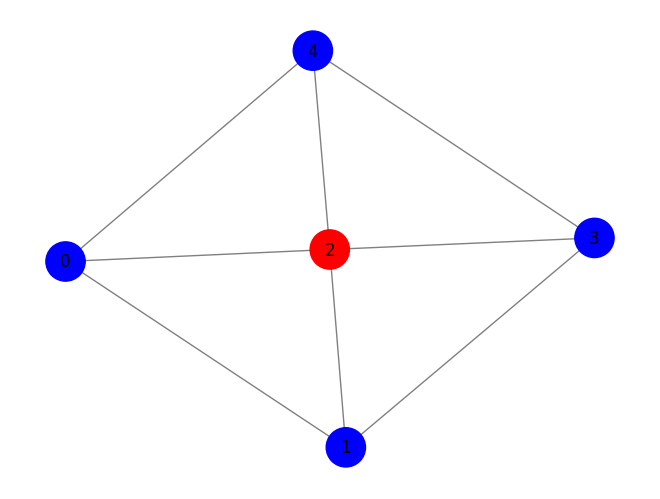

In [40]:
J = np.array([
    [0, 1, 1, 0, 1],  # Node 0 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0],  # Node 1 connected to nodes 0, 2, 3
    [1, 1, 0, 1, 1],  # Node 2 connected to nodes 0, 1, 3, 4
    [0, 1, 1, 0, 1],  # Node 3 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0]   # Node 4 connected to nodes 0, 2, 3
])


G = nx.from_numpy_array(J)
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, font_size=12)
# plt.show()

# Initialize the DSB class with our coupling matrix
dsb_instance = DSB(
    J=J,
    batch_size=5,  # Track 3 independent samples
    n_iter=5000     # Number of iterations to run
)

# Store the history of x values and cut values to visualize the evolution
x_history = []
cut_history = []

# Save initial state
x_history.append(dsb_instance.x.copy())
cut_history.append(dsb_instance.calc_cut())

# Run the update function
dsb_instance.update()

# Get final state
final_x = dsb_instance.x
final_cut = dsb_instance.calc_cut()

print("Initial spin values:")
print(x_history[0])
print("\nInitial cut values:")
print(cut_history[0])

print("\nFinal spin values:")
print(final_x)
print("\nFinal cut values:")
print(final_cut)

# Check the final state - the values should converge to near +1 or -1
print("\nFinal spin signs:")
print("\nFinal spin signs diagonal:")
diagonal_elements = np.sign(np.diagonal(final_x))
print(diagonal_elements)


# Calculate improvement in cut value
print(f"\nImprovement in cut value: {final_cut - cut_history[0]}")

node_colors = ['red' if v == 1 else 'blue' for v in diagonal_elements]
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_size=12)
plt.show()